In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import optimize
import umodel as unf

import matplotlib as mpl
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize'] = (10, 7)

In [2]:
# Loading data cos(n, -)
with open('../data/CosThetaNminus/asimov_spinCorrelation.json', 'r') as read_file:
    dm = np.array(json.load(read_file))
    
with open('../data/CosThetaNminus/resmat_spinCorrelation.json', 'r') as read_file:
    rm = np.array(json.load(read_file))

    
# Loading data cos(n, +)
with open('../data/CosThetaNplus/asimov_spinCorrelation.json', 'r') as read_file:
    dp = np.array(json.load(read_file))
    
with open('../data/CosThetaNplus/resmat_spinCorrelation.json', 'r') as read_file:
    rp = np.array(json.load(read_file))

    
# Loading data correlations between the two observables
with open('../data/correlation_matrix_CosThetaNplus_CosThetaNminus_bins.json', 'r') as read_file:
    corrDict = json.load(read_file)

n, p = rm.shape[0], rp.shape[0]
corr = np.zeros((n+p, n+p))
for i, (iName, line) in enumerate(corrDict.items()):
    for j, (jName, c) in enumerate(line.items()):
        corr[i, j] = c

In [3]:
def showMat(m, percent=False):
    plt.matshow(m, cmap='Wistia')
    msg = '{:.0e}'
    if percent:
        msg = '{:.0f}'
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            plt.text(i, j, msg.format(m[j, i]), va='center', ha='center', fontsize=12)

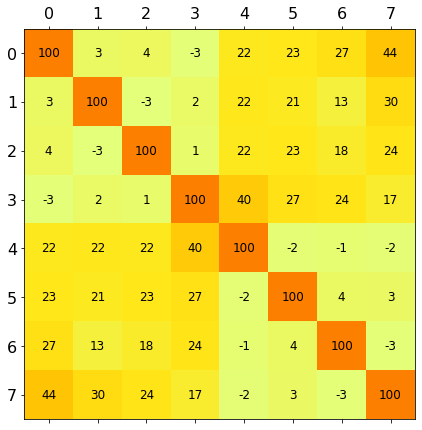

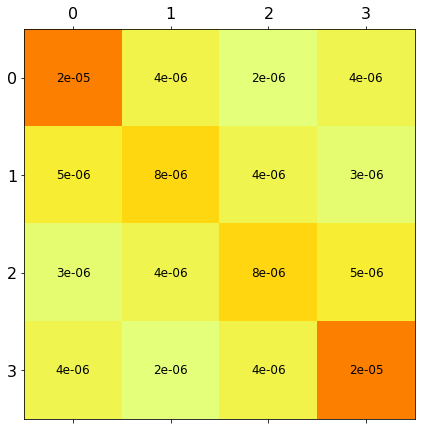

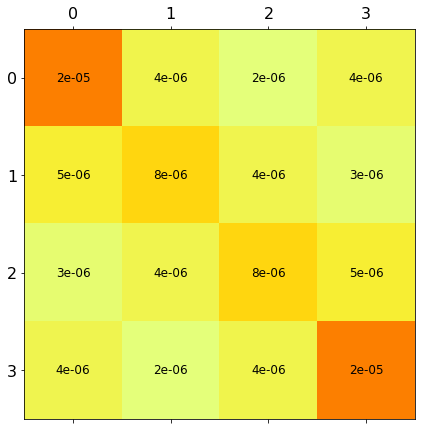

In [4]:
showMat(corr*100, True)
showMat(rm)
showMat(rp)

In [5]:
def plotResult(xEdges, valueErrors):
    
    '''
    This function plot the post-fit unfolded bins 
    versus the unfolded observables values.
    
    xEdges: 1D array with edges of observable values
    valueErrors: list of 2D array of shape (N, 3) with N POIs
                 measurment with central value, negative and 
                 positive error.
    '''
    
    # Plot the result
    plt.figure(figsize=(15, 6))

    # x-data for binned-like plotting
    xUp, xDown = xEdges[1:], xEdges[:-1]
    xCenter = (xUp + xDown) / 2
    
    # Labels
    xlabels = ['cos($\\theta^{+}_{n}$)', 'cos($\\theta^{-}_{n}$)']
    
    for i, distri in enumerate(valueErrors):
    
        # y-data
        vals = distri[:, 0]
        errn = distri[:, 1]
        errp = distri[:, 2]

        # Plot
        plt.subplot(1, 2, i+1)
        plt.plot(xCenter, vals, 'o', markersize=10)
        plt.hlines(y=vals, xmin=xDown, xmax=xUp, color='tab:blue')
        plt.vlines(x=xCenter, ymin=vals-errn, ymax=vals+errp, color='tab:blue')
        plt.ylabel('Reco Yields')
        plt.xlabel(xlabels[i])
        plt.ylim(10e3, 30e3)
        plt.tight_layout()

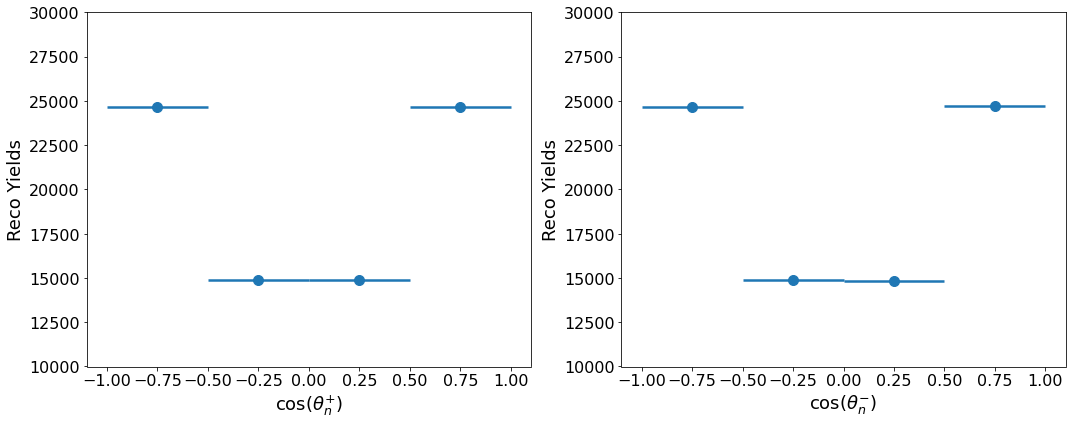

In [6]:
Xs = np.array([-1.0, -0.5, 0, 0.5, 1.0])
valueErrors = []

valDM = np.zeros(shape=(dm.shape[0], 3))
valDM[:, 0] = dm
valDM[:, 1] = np.sqrt(dm)
valDM[:, 2] = np.sqrt(dm)
valueErrors.append(valDM)

valDP = np.zeros(shape=(dm.shape[0], 3))
valDP[:, 0] = dp
valDP[:, 1] = np.sqrt(dp)
valDP[:, 2] = np.sqrt(dp)
valueErrors.append(valDP)

plotResult(Xs, valueErrors)

In [7]:
Ds = [dp, dm]
Rs = [rp, rm]
mCorr = unf.model(Ds, Rs, corr)
m = unf.model(Ds, Rs, corr=np.diag([1]*8))

In [8]:
# Run with correlation
BsCorr, _ = mCorr.unfold()
POIsCorr  = mCorr.postFitUncerPOIs()

In [9]:
# Run without correlations
Bs, _ = m.unfold()
POIs = m.postFitUncerPOIs()

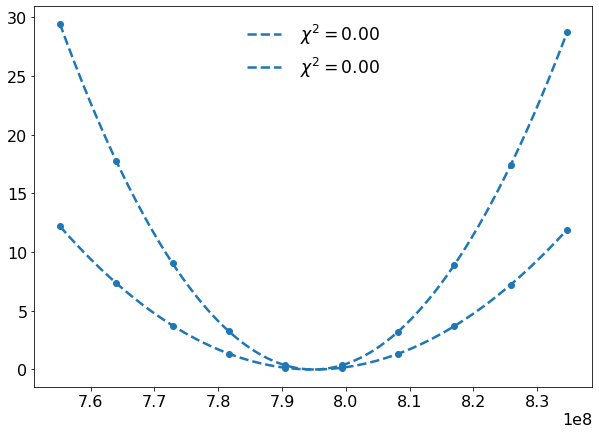

In [10]:
# Try to overlay two plots
i, xMin, xMax, n = 3, 755180426.5842565,834673103.06681, 10
mCorr.plotProfile(i, xMin, xMax, n)
m.plotProfile(i, xMin, xMax, n)

In [11]:
# Comparing result w/ and w/o corr from direct unfolding (full minimzation, only central values)
# --> no differences
bpCorr = BsCorr[0]
bmCorr = BsCorr[1]
bp = Bs[0]
bm = Bs[1]
print((bpCorr-bp)/bp)
print((bmCorr-bm)/bm)

[ 7.49768577e-16  1.50477593e-16  1.50490481e-16 -1.49962606e-16]
[ 4.50096366e-16 -3.00819984e-16  6.01797976e-16 -1.49990672e-16]


In [12]:
# Comparing results w/ and w/o corr from profile LH
# --> differences from ~1% to 20% level!
POIsCorr = np.concatenate(POIsCorr)
POIs = np.concatenate(POIs)
relDiff = (POIsCorr-POIs) / POIs[:, 0, np.newaxis]
print( relDiff[:, 0] )

[-0.00020518 -0.00026034 -0.00026034 -0.00015264 -0.00015264 -0.00026034
 -0.00026034 -0.00015264]


In [13]:
# Comparing results between unfolded and profile, w/o corr
# --> no differences
for m1, m2 in zip(POIs, np.concatenate([bp, bm])):
    print((m1[0] - m2)/m1[0])

0.00010259207638850987
0.00015775789130366348
0.00015775789130376746
0.00010259207638850248
0.0001025920763886014
0.00015775789130375643
0.0001577578913036989
0.00010259207638850274


In [14]:
# Comparing results between unfolded and profiled, w/ corr
# --> large differences (from ~3% to 25%)!
for m1, m2 in zip(POIsCorr, np.concatenate([bpCorr, bmCorr])):
    print((m1[0] - m2)/m1[0])

-0.00010261313097685306
-0.00010261313097689953
-0.00010261313097691131
-5.0052555182998784e-05
-5.005255518293361e-05
-0.00010261313097687056
-0.00010261313097687037
-5.005255518293307e-05


In [15]:
def f(x, a0, a1, a2, a3):
    return a0 + a1*x + a2*x**2 + a3*x**3

def chi2_nDof(obs, exp):
    nDoF = len(obs)-1
    return np.sum( (exp-obs)**2/exp ) / nDoF


def compareProfile(i, xMin=0.75e9, xMax=0.85e9, n=20):
    
    yLabel = '$\\Delta$ NLL'
    xLabel = 'cos$\\theta^{+}_{n}$' + '   bin {}'.format(i)
    if i>3 :
        xLabel = 'cos$\\theta^{-}_{n}$' + '   bin {}'.format(i-4)
    
    val1, nll1 = m.profilePOI(iPOI=i, POImin=xMin, POImax=xMax, nScan=n)
    p1, _ = optimize.curve_fit(f, val1, nll1)
    plt.plot(val1, nll1, 'o', color='tab:blue')
    v1 = np.linspace(val1.min(), val1.max(), 1000)
    n1 = f(v1, *p1)
    plt.plot(v1, n1, '--', color='tab:blue', label='w/o corr')
    
    dy1 = f(val1, *p1) - nll1
    chi21 = np.mean(dy1**2)
    print(chi21)
    
    val2, nll2 = mCorr.profilePOI(iPOI=i,  POImin=xMin, POImax=xMax, nScan=n)
    p2, _ = optimize.curve_fit(f, val2, nll2)
    plt.plot(val2, nll2, 'o', color='tab:red')
    v2 = np.linspace(val2.min(), val2.max(), 1000)
    n2 = f(v2, *p2)
    plt.plot(v2, n2, '--', color='tab:red', label='w/ corr')
    
    dy2 = f(val2, *p2) - nll2
    chi22 = np.sum(dy2**2) 
    print(chi22)
    
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.legend();

POI=8.13e+08 is not kept (fit didn't converge)
POI=8.15e+08 is not kept (fit didn't converge)
POI=8.17e+08 is not kept (fit didn't converge)
POI=8.19e+08 is not kept (fit didn't converge)
POI=8.21e+08 is not kept (fit didn't converge)
3.4215239529486e-11
POI=8.13e+08 is not kept (fit didn't converge)
POI=8.15e+08 is not kept (fit didn't converge)
POI=8.17e+08 is not kept (fit didn't converge)
POI=8.19e+08 is not kept (fit didn't converge)
POI=8.21e+08 is not kept (fit didn't converge)
1.329072634551031e-09


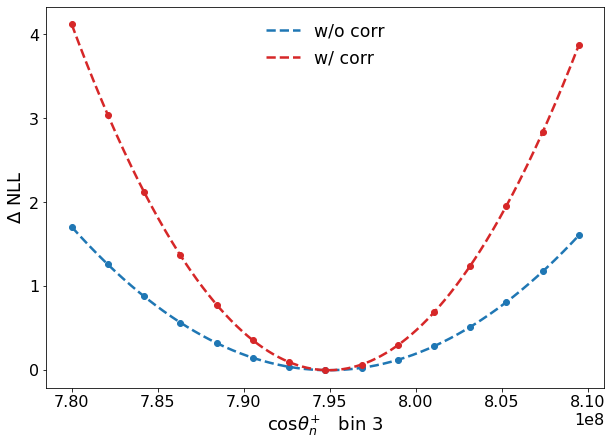

In [18]:
compareProfile(3, xMin=0.78e9, xMax=0.82e9, n=20)

POI=8.29e+08 is not kept (fit didn't converge)
POI=8.34e+08 is not kept (fit didn't converge)
POI=8.38e+08 is not kept (fit didn't converge)
POI=8.42e+08 is not kept (fit didn't converge)
1.9318933376507963e-13
POI=8.29e+08 is not kept (fit didn't converge)
POI=8.34e+08 is not kept (fit didn't converge)
POI=8.38e+08 is not kept (fit didn't converge)
POI=8.42e+08 is not kept (fit didn't converge)
1.3730935645192186e-09


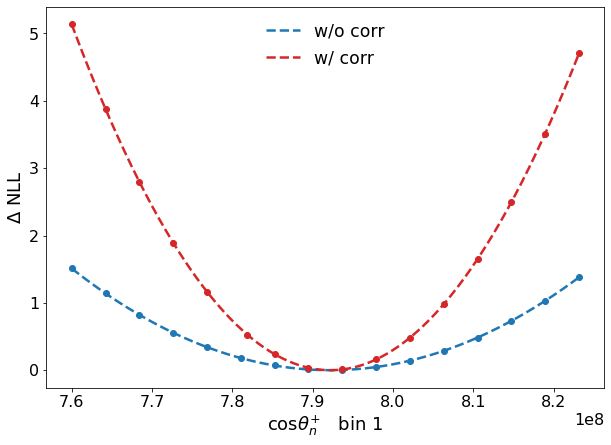

In [21]:
compareProfile(1, xMin=0.76e9, xMax=0.84e9, n=20)

POI=8.13e+08 is not kept (fit didn't converge)
POI=8.15e+08 is not kept (fit didn't converge)
POI=8.17e+08 is not kept (fit didn't converge)
POI=8.19e+08 is not kept (fit didn't converge)
POI=8.21e+08 is not kept (fit didn't converge)
2.4647886261350478e-12
POI=8.10e+08 is not kept (fit didn't converge)
POI=8.13e+08 is not kept (fit didn't converge)
POI=8.15e+08 is not kept (fit didn't converge)
POI=8.17e+08 is not kept (fit didn't converge)
POI=8.19e+08 is not kept (fit didn't converge)
POI=8.21e+08 is not kept (fit didn't converge)
0.009938747906887303


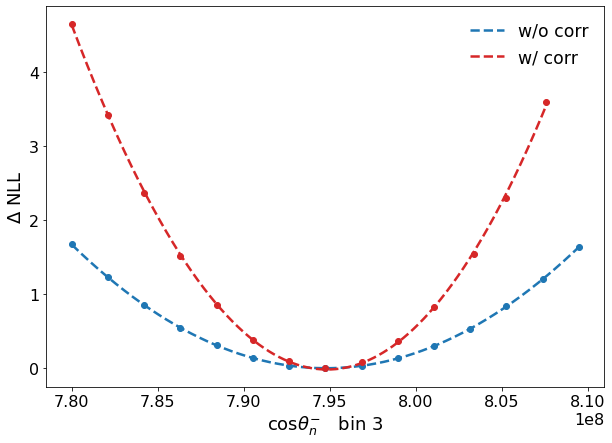

In [20]:
compareProfile(7, xMin=0.78e9, xMax=0.82e9, n=20)

POI=8.13e+08 is not kept (fit didn't converge)
POI=8.15e+08 is not kept (fit didn't converge)
POI=8.17e+08 is not kept (fit didn't converge)
POI=8.19e+08 is not kept (fit didn't converge)
POI=8.21e+08 is not kept (fit didn't converge)
2.4365426315052423e-12
POI=8.13e+08 is not kept (fit didn't converge)
POI=8.15e+08 is not kept (fit didn't converge)
POI=8.17e+08 is not kept (fit didn't converge)
POI=8.19e+08 is not kept (fit didn't converge)
POI=8.21e+08 is not kept (fit didn't converge)
6.131160199128143e-12


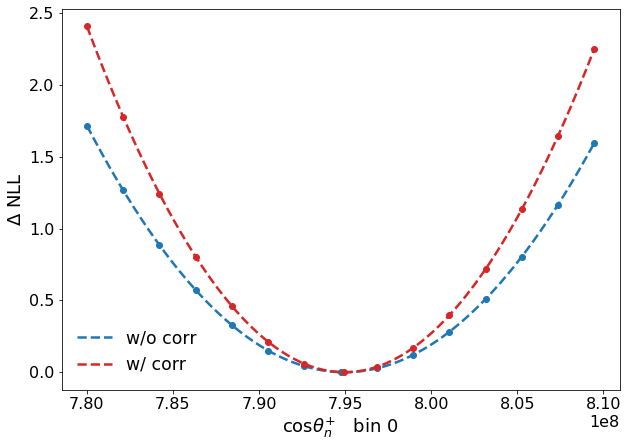

In [17]:
compareProfile(0, xMin=0.78e9, xMax=0.82e9, n=20)

POI=8.34e+08 is not kept (fit didn't converge)
POI=8.38e+08 is not kept (fit didn't converge)
POI=8.42e+08 is not kept (fit didn't converge)
1.8155297596519392e-09


/home/rmadar/cernbox/PythonDev/unfoldcorr/umodel/umodel.py:136: RuntimeWarning: invalid value encountered in sqrt
  Sigma[i, j] = self.Corr[i, j] * np.sqrt(mu[i] * mu[j])


POI=8.34e+08 is not kept (fit didn't converge)
POI=8.38e+08 is not kept (fit didn't converge)
POI=8.42e+08 is not kept (fit didn't converge)
1.8943313106046145
POI=8.29e+08 is not kept (fit didn't converge)
POI=8.34e+08 is not kept (fit didn't converge)
POI=8.38e+08 is not kept (fit didn't converge)
POI=8.42e+08 is not kept (fit didn't converge)
1.9318933376507963e-13
POI=8.29e+08 is not kept (fit didn't converge)
POI=8.34e+08 is not kept (fit didn't converge)
POI=8.38e+08 is not kept (fit didn't converge)
POI=8.42e+08 is not kept (fit didn't converge)
1.3730935645192186e-09
POI=8.29e+08 is not kept (fit didn't converge)
POI=8.34e+08 is not kept (fit didn't converge)
POI=8.38e+08 is not kept (fit didn't converge)
POI=8.42e+08 is not kept (fit didn't converge)
2.782576304163933e-13
POI=8.29e+08 is not kept (fit didn't converge)
POI=8.34e+08 is not kept (fit didn't converge)
POI=8.38e+08 is not kept (fit didn't converge)
POI=8.42e+08 is not kept (fit didn't converge)
2.2087811353345844e-

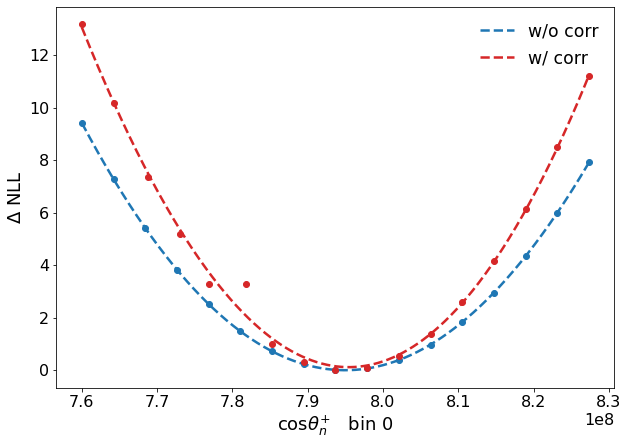

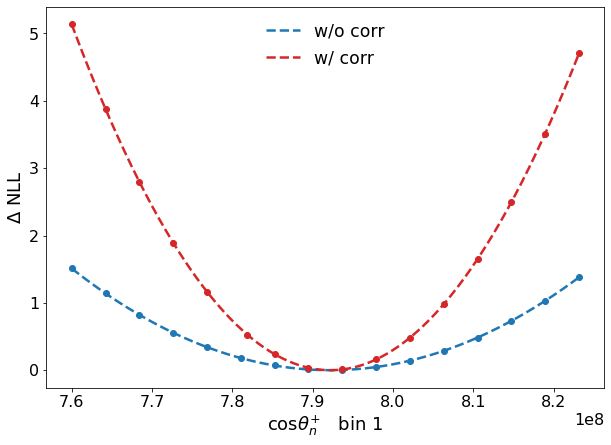

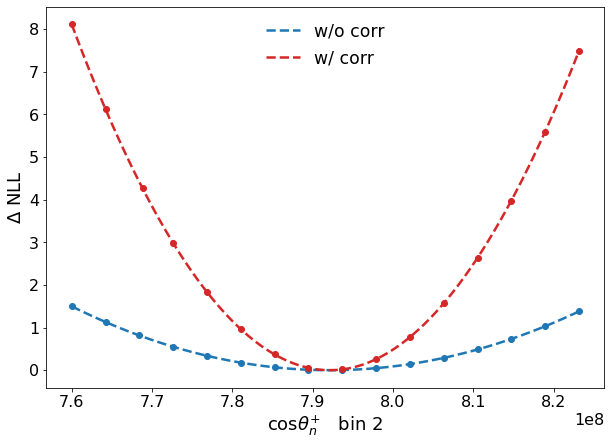

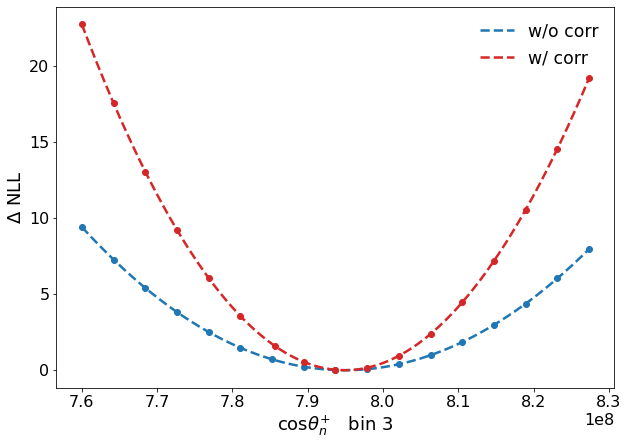

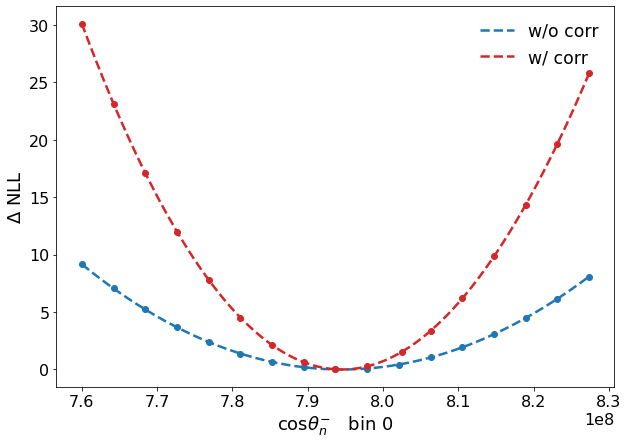

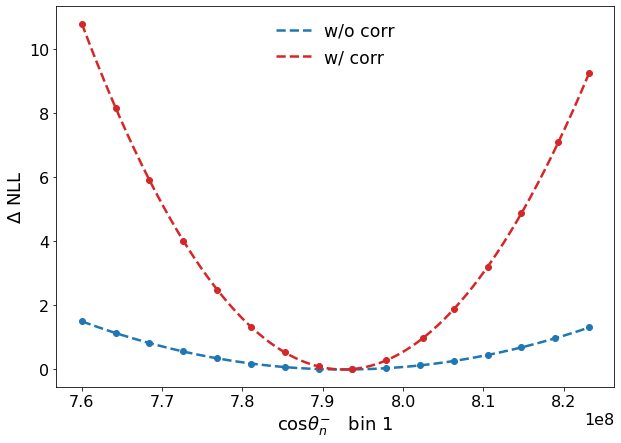

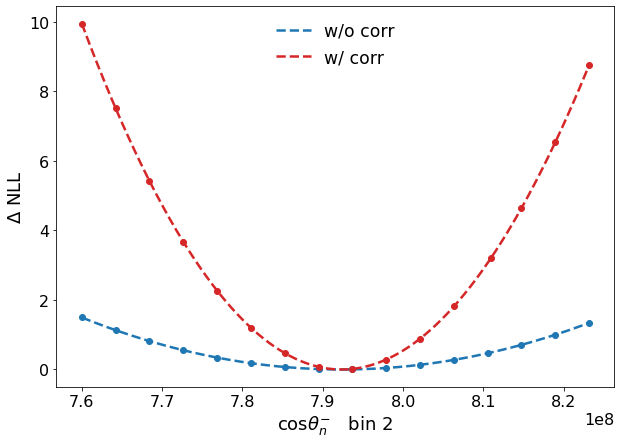

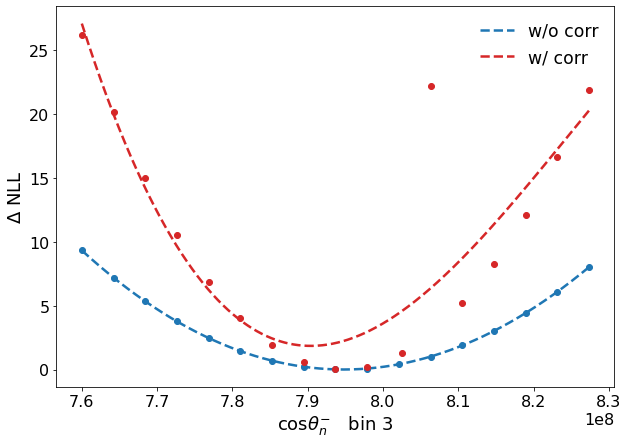

In [70]:
for i in range(8):
    plt.figure()
    compareProfile(i, xMin=0.76e9, xMax=0.84e9, n=20)

POI=8.27e+08 is not kept (fit didn't converge)
POI=8.32e+08 is not kept (fit didn't converge)
1.5746555603445212e-10
POI=8.27e+08 is not kept (fit didn't converge)
POI=8.32e+08 is not kept (fit didn't converge)
2.0308282867993844e-06


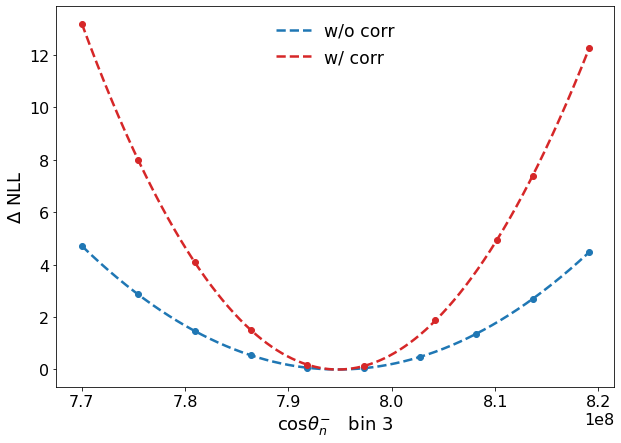

In [94]:
compareProfile(7, xMin=0.77e9, xMax=0.83e9, n=12)

POI=8.27e+08 is not kept (fit didn't converge)
POI=8.32e+08 is not kept (fit didn't converge)
1.621307227075286e-10
POI=8.27e+08 is not kept (fit didn't converge)
POI=8.32e+08 is not kept (fit didn't converge)
2.1145896608200001e-10


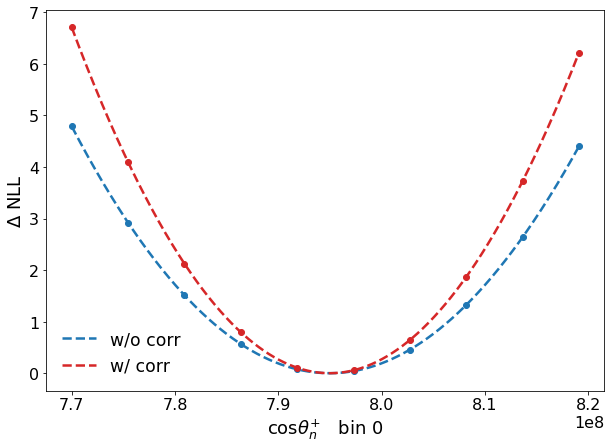

In [97]:
compareProfile(0, xMin=0.77e9, xMax=0.83e9, n=12)

In [16]:
def plotResult(xEdges, postFitPOIs1, postFitPOIs2):
    
    '''
    This function plot the post-fit unfolded bins 
    versus the unfolded observables values.
    
    xEdges: 1D array with edges of observable values
    postFitPOIs: 2D array of shape (N, 3) with N POI measurment
                 with central value, negative and positive error.
    '''
    
    # Plot the result
    plt.figure(figsize=(15, 5))

    # x-data for binned-like plotting
    xUp, xDown = xEdges[1:], xEdges[:-1]
    xCenter = (xUp + xDown) / 2
    
    # Labels
    xlabels = ['cos($\\theta^{+}_{n}$)', 'cos($\\theta^{-}_{n}$)']
    
    for i, (distri1, distri2) in enumerate(zip(postFitPOIs1, postFitPOIs2)):
    
        # y-data
        vals1 = distri1[:, 0]
        errn1 = distri1[:, 1]
        errp1 = distri1[:, 2]
        vals2 = distri2[:, 0]
        errn2 = distri2[:, 1]
        errp2 = distri2[:, 2]

        # Plot
        plt.subplot(1, 2, i+1)
        plt.plot(xCenter-0.05, vals1, 'o', markersize=10)
        #plt.hlines(y=vals1, xmin=xDown, xmax=xUp, color='tab:blue')
        plt.vlines(x=xCenter-0.05, ymin=vals1-errn1, ymax=vals1+errp1, color='tab:blue', label='w/o corr')
        plt.legend()
        
        plt.plot(xCenter+0.05, vals2, 'o', markersize=10, color='tab:red')
        #plt.hlines(y=vals2, xmin=xDown, xmax=xUp, color='tab:red')
        plt.vlines(x=xCenter+0.05, ymin=vals2-errn2, ymax=vals2+errp2, color='tab:red', label='w/ corr')
        plt.ylabel('Unfolded Yields')
        plt.xlabel(xlabels[i])
        plt.ylim(7e8, 9e8)
        plt.legend()
        
        
def plotErrorBarRatio(xEdges, postFitPOIs1, postFitPOIs2):
    # Plot the result
    plt.figure(figsize=(15, 5))

    # x-data for binned-like plotting
    xUp, xDown = xEdges[1:], xEdges[:-1]
    xCenter = (xUp + xDown) / 2
    
    # Labels
    xlabels = ['cos($\\theta^{+}_{n}$)', 'cos($\\theta^{-}_{n}$)']
    
    for i, (distri1, distri2) in enumerate(zip(postFitPOIs1, postFitPOIs2)):
    
        # y-data
        bar1 =  distri1[:, 2] + distri1[:, 1]
        bar2 =  distri2[:, 2] + distri2[:, 1]

        # Plot figure
        plt.subplot(1, 2, i+1)
        
        # Plot data
        plt.plot(xCenter, bar2 / bar1, markersize=10, marker='o')
        
        # Plot cosmetics
        plt.ylabel('Error Bar Ratio')
        plt.xlabel(xlabels[i])
        plt.ylim(0.0, 2.0)

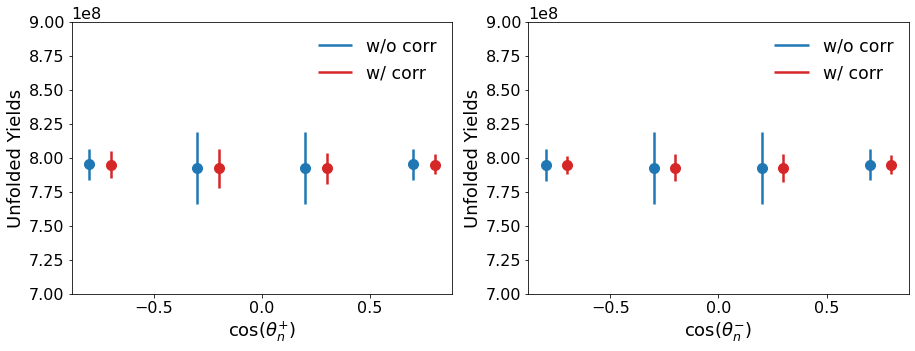

In [17]:
Xs = np.array([-1.0, -0.5, 0, 0.5, 1.0])
plotResult(Xs, m._array2list(POIs), m._array2list(POIsCorr))

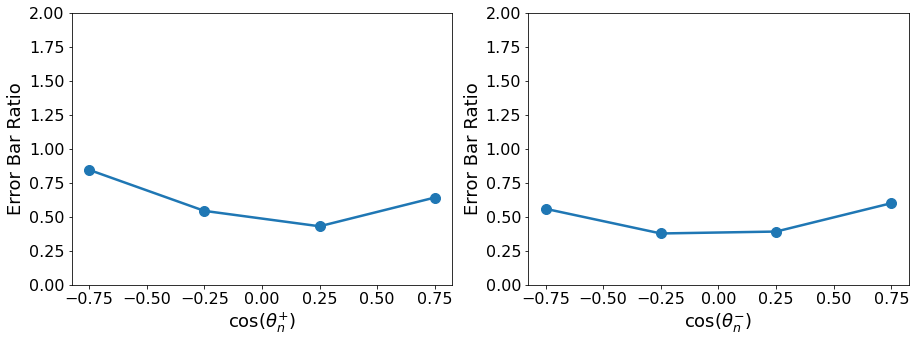

In [18]:
plotErrorBarRatio(Xs, m._array2list(POIs), m._array2list(POIsCorr))

[[1. 0. 0. 0. 1. 1. 1. 1.]
 [0. 1. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0. 1. 0.]
 [1. 1. 1. 1. 0. 0. 0. 1.]]


2.0887626735967214e-27

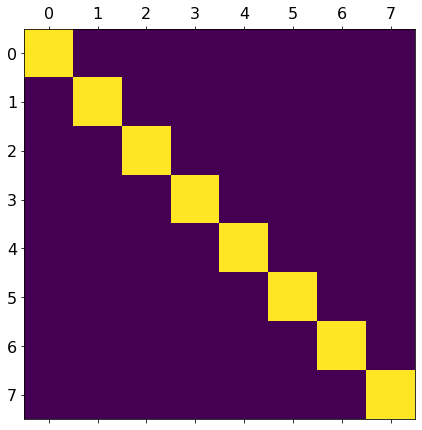

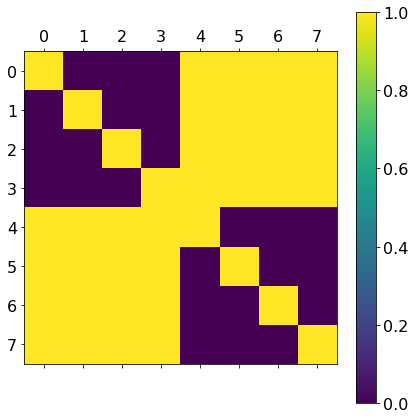

In [47]:
fullCorr = np.diag([1]*8).astype(np.float64)
plt.matshow(fullCorr)

for i in range(0, 4):
    for j in range(0, 4):
        fullCorr[i, j+4] = 1.0
        fullCorr[i+4, j] = 1.0

plt.matshow(fullCorr)
print(fullCorr)
plt.colorbar();

mSameCorr = unf.model([dp, dp], [rp, rp], fullCorr)
mSame = unf.model([dp, dp], [rp, rp], corr=np.diag([1]*8))

mSameCorr.NLL(mSameCorr.Bs)

In [44]:
poiSame = mSame.postFitUncerPOIs()

In [39]:
poiSameCorr = mSameCorr.postFitUncerPOIs()

/home/rmadar/cernbox/PythonDev/unfoldcorr/umodel/umodel.py:136: RuntimeWarning: invalid value encountered in sqrt
  Sigma[i, j] = self.Corr[i, j] * np.sqrt(mu[i] * mu[j])


ValueError: array must not contain infs or NaNs

In [ ]:
plotResult(Xs, poiSame, poiSameCorr)
plotErrorBarRatio(Xs, poiSame, poiSameCorr)

In [48]:
1./np.sqrt(2.)

0.7071067811865475